In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from util import count_edge_crossings

# Notebook to analyze answers to edge crossing counting tasks

In [4]:
number_r = re.compile(r"^\d*[.,]?\d*$")

## Load the queries

In [5]:
def parse_crossing_query(query: str):
    query = query.split("\n")
    layer_a_str = query[3]
    layer_b_str = query[4]
    edges_str = query[7]

    layer_a = ast.literal_eval(layer_a_str.split("A:")[1].strip())
    layer_b = ast.literal_eval(layer_b_str.split("B:")[1].strip())
    edges = ast.literal_eval(edges_str.split("Tuples:")[1].strip())

    return edges, {0: layer_a, 1: layer_b}

In [6]:
cross_query_dir = "queries/crossings_prompts_steps"
cross_query_files = set(sorted(os.listdir(cross_query_dir)))
print("Number of crossing queries: {}".format(len(cross_query_files)))

cross_queries = {}
cross_queries_gt = {}
for query_file in cross_query_files:
    with open(os.path.join(cross_query_dir, query_file), "r") as f:
        query = f.read()
        edges, ranks = parse_crossing_query(query)
        cross_queries[query_file] = (edges, ranks)
        gt = count_edge_crossings(edges, ranks)
        cross_queries_gt[query_file] = gt

Number of crossing queries: 94


In [7]:
cross_queries_gt_ct = Counter(cross_queries_gt.values())
print(cross_queries_gt_ct.most_common())

[(0.0, 85), (1.0, 3), (2.0, 3), (3.0, 2), (7.0, 1)]


## Load answers -- Standard

In [8]:
cross_std_answers_dir = "answers/crossings_prompts"
cross_std_answers_files = set(os.listdir(cross_std_answers_dir))
print("Number of crossing standard answers: {}".format(len(cross_std_answers_files)))

Number of crossing standard answers: 94


In [9]:
cross_std_tuples = {}
cross_std_not_tuples = {}
cross_std_no = {}

for cross_std_file in sorted(cross_std_answers_files):
    # if cross_std_file != "grafo2931.11_2_3.txt":continue

    answer = open(os.path.join(cross_std_answers_dir, cross_std_file), "r").read()
    # print(answer)

    a_lines = answer.split("\n")
    if len(a_lines) == 1:

        # If "no" is in the answer, then likely there were no crossings
        if "no" in answer:
            cross_std_no[cross_std_file] = answer
            continue

        # There are cases in which the model replied with a single tuple 
        # instead of two. We can filter those out as malformed answers
        if answer.count("(") == 1 and answer.count(")") == 1:
            cross_std_not_tuples[cross_std_file] = answer
            continue
    
    tuples_in_answer = []
    # print(a_lines)
    for a_line in a_lines:
        if a_line == "":
            continue
        
        if a_line.split()[-1] == "cross.": 
            a_line = a_line[:-6]
        if a_line.split()[-1] == "cross":
            a_line = a_line[:-5]

        # print(a_line)

        if "and" in a_line:
            a_line = a_line.split("and")
        elif "->" in a_line:
            a_line = a_line.split("->")
        elif "-" in a_line:
            a_line = a_line.split("-")
        elif "crosses with" in a_line:
            a_line = a_line.split("crosses with")
        elif "crosses" in a_line:
            a_line = a_line.split("crosses")
        elif "), (" in a_line:
            a_line = a_line.split("), (")
            a_line[0] = a_line[0] + ")"
            a_line[-1] = "(" + a_line[1]
        elif ") (" in a_line:
            a_line = a_line.split(") (")
            a_line[0] = a_line[0] + ")"
            a_line[-1] = "(" + a_line[1]

        # print(a_line)
        if len(a_line) != 2:
            continue

        try:
            tup_0 = ast.literal_eval(a_line[0].strip())
            tup_1 = ast.literal_eval(a_line[1].strip())
            tuples_in_answer.append((tup_0, tup_1))
        
        except Exception as e:
            # print("Exception: {} - {} - {}".format(a_line[0], a_line[1], e))
            continue

    if len(tuples_in_answer) == 0:
        cross_std_not_tuples[cross_std_file] = answer
        continue

    cross_std_tuples[cross_std_file] = len(tuples_in_answer)

In [10]:
# We manually checked the "no" answers and they all correspond to no crossings
print("Number of crossing standard answers that are 'no': {}".format(len(cross_std_no)))
to_remove_std = list(cross_std_no.keys())
for ans in to_remove_std:
    cross_std_tuples[ans] = 0
    del cross_std_no[ans]

Number of crossing standard answers that are 'no': 18


In [11]:
print("Number of crossing standard answers that are not tuples: {}".format(len(cross_std_not_tuples)))

# We can manually look at the potentially malformed answers
# display(cross_std_not_tuples)
add_std_valid = {}
add_std_valid["grafo267.11_3_4.txt"] = 0
add_std_valid["grafo376.10_0_1.txt"] = 0
add_std_valid["grafo376.10_1_2.txt"] = 1
add_std_valid["grafo532.11_3_4.txt"] = 1
add_std_valid["grafo541.10_4_5.txt"] = 1
add_std_valid["grafo857.11_1_2.txt"] = 0
for k in add_std_valid.keys():
    cross_std_tuples[k] = add_std_valid[k]
    del cross_std_not_tuples[k]

Number of crossing standard answers that are not tuples: 12


In [12]:
print("Number of crossing standard answers that are numbers: {}".format(len(cross_std_tuples)))
print("Number of crossing standard answers that are not tuples: {}".format(len(cross_std_not_tuples)))

Number of crossing standard answers that are numbers: 88
Number of crossing standard answers that are not tuples: 6


In [13]:
std_correct = 0.0
std_more = 0.0
std_less = 0.0
std_wrong = float(len(cross_std_not_tuples))

for cross_std_file, answer in cross_std_tuples.items():
    gt = cross_queries_gt[cross_std_file]
    if answer == gt:
        std_correct += 1.0
    elif answer > gt:
        std_more += 1.0
    else:
        std_less += 1.0

std_data = {
    "Correct": std_correct,
    "Incorrect >": std_more,
    "Incorrect <": std_less,
    "Malformed": std_wrong
}
std_df = pd.DataFrame.from_dict(std_data, orient="index", columns=["Count"])

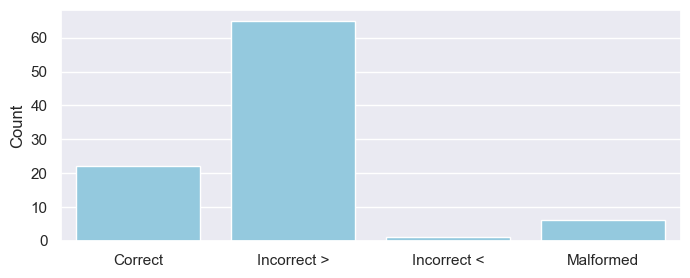

In [14]:
sns.set(rc={'figure.figsize':(8,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=std_df.index, y='Count', data=std_df, color='skyblue')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

## Load answers -- Step

In [15]:
cross_step_answers_dir = "answers/crossings_prompts_steps"
cross_step_answers_files = sorted(os.listdir(cross_step_answers_dir))
print("Number of crossing Step answers: {}".format(len(cross_step_answers_files)))

Number of crossing Step answers: 94


In [16]:
cross_step_is_number = {}
cross_step_not_number = {}

for cross_step_file in cross_step_answers_files:
    answer = open(os.path.join(cross_step_answers_dir, cross_step_file), "r").read().strip()
    answer = answer.split("\n")[-1].strip()
    
    answer = answer.split()

    numbers_in_line = []

    for a_word in answer:
        # Remove ","
        a_word = a_word.replace(",", "")
        if number_r.match(a_word):
            try:
                a_nun = float(a_word)
                numbers_in_line.append(a_nun)
            except:
                continue
    if len(numbers_in_line) == 0:
        cross_step_not_number[cross_step_file] = answer
    else:
        cross_step_is_number[cross_step_file] = numbers_in_line[-1]

print("Answer is a number:", len(cross_step_is_number))
print("Answer is not a number:", len(cross_step_not_number))
print(cross_step_not_number.keys())

cross_step_integer = {}
cross_step_float = {}
for cross_step_file, answer in cross_step_is_number.items():
    if answer.is_integer():
        cross_step_integer[cross_step_file] = int(answer)
    else:
        cross_step_float[cross_step_file] = answer

print("Answer is an Integer:", len(cross_step_integer))
print("Answer is a Float:", len(cross_step_float))

Answer is a number: 86
Answer is not a number: 8
dict_keys(['grafo1657.10_1_2.txt', 'grafo2105.10_0_1.txt', 'grafo219.11_0_1.txt', 'grafo2964.11_2_3.txt', 'grafo376.10_0_1.txt', 'grafo462.10_2_3.txt', 'grafo717.10_0_1.txt', 'grafo938.10_2_3.txt'])
Answer is an Integer: 86
Answer is a Float: 0


In [17]:
# We can manually analyze the answers that are not parsed as numbers
# grafo1657.10_1_2.txt, grafo2964.11_2_3.txt are malformed
additional_cross_step_number = {}
additional_cross_step_number["grafo2105.10_0_1.txt"] = 0
additional_cross_step_number["grafo219.11_0_1.txt"] = 0
additional_cross_step_number["grafo376.10_0_1.txt"] = 0
additional_cross_step_number["grafo462.10_2_3.txt"] = 0
additional_cross_step_number["grafo717.10_0_1.txt"] = 0
additional_cross_step_number["grafo938.10_2_3.txt"] = 0
for k in additional_cross_step_number:
    _ = cross_step_not_number.pop(k)

In [18]:
step_correct = 0.0
step_more = 0.0
step_less = 0.0
step_wrong = float(len(cross_step_not_number) + len(cross_step_float))

for cross_step_file, answer in cross_step_integer.items():
    gt = cross_queries_gt[cross_step_file]
    if answer == gt:
        step_correct += 1.0
    elif answer > gt:
        step_more += 1.0
    else:
        step_less += 1.0

step_data = {
    "Correct": step_correct,
    "Incorrect >": step_more,
    "Incorrect <": step_less,
    "Malformed": step_wrong
}
step_df = pd.DataFrame.from_dict(step_data, orient="index", columns=["Count"])

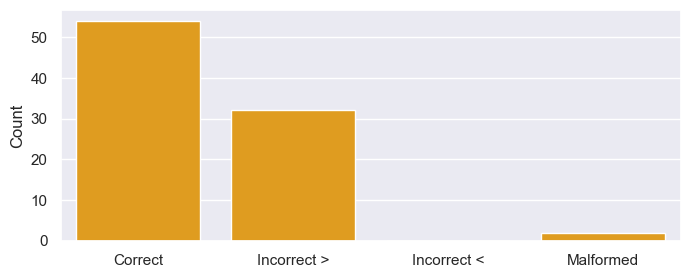

In [19]:
sns.set(rc={'figure.figsize':(8,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=step_df.index, y='Count', data=step_df, color='orange')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

## Load answers -- ICL

In [20]:
cross_icl_answers_dir = "answers/crossings_prompts_icl"
cross_icl_answers_files = sorted(os.listdir(cross_icl_answers_dir))
print("Number of crossing ICL answers: {}".format(len(cross_icl_answers_files)))

Number of crossing ICL answers: 94


In [21]:
cross_icl_is_number = {}
cross_icl_not_number = {}

for cross_icl_file in cross_icl_answers_files:
    answer = open(os.path.join(cross_icl_answers_dir, cross_icl_file), "r").read().strip()
    answer = answer.split("\n")[-1].strip()
    
    if number_r.match(answer):
        cross_icl_is_number[cross_icl_file] = float(answer)
    else:
        cross_icl_not_number[cross_icl_file] = answer

print("Answer is a number:", len(cross_icl_is_number))
print("Answer is not a number:", len(cross_icl_not_number))
print(cross_icl_not_number.keys())

cross_icl_integer = {}
cross_icl_float = {}
for cross_icl_file, answer in cross_icl_is_number.items():
    if answer.is_integer():
        cross_icl_integer[cross_icl_file] = int(answer)
    else:
        cross_icl_float[cross_icl_file] = answer

print("Answer is an Integer:", len(cross_icl_integer))
print("Answer is a Float:", len(cross_icl_float))

Answer is a number: 94
Answer is not a number: 0
dict_keys([])
Answer is an Integer: 94
Answer is a Float: 0


In [22]:
icl_correct = 0.0
icl_more = 0.0
icl_less = 0.0
icl_wrong = float(len(cross_icl_not_number) + len(cross_icl_float))

for cross_icl_file, answer in cross_icl_integer.items():
    gt = cross_queries_gt[cross_icl_file]
    if answer == gt:
        icl_correct += 1.0
    elif answer > gt:
        icl_more += 1.0
    else:
        icl_less += 1.0

icl_data = {
    "Correct": icl_correct,
    "Incorrect >": icl_more,
    "Incorrect <": icl_less,
    "Malformed": icl_wrong
}
icl_df = pd.DataFrame.from_dict(icl_data, orient="index", columns=["Count"])

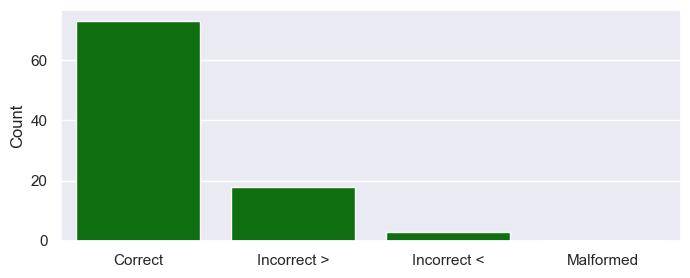

In [23]:
sns.set(rc={'figure.figsize':(8,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=icl_df.index, y='Count', data=icl_df, color='green')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

## Side by side comparison

In [24]:
std_pt = std_df / len(cross_std_answers_files) * 100
step_pt = step_df / len(cross_step_answers_files) * 100
icl_pt = icl_df / len(cross_icl_answers_files) * 100


std_pt["Type"] = "Standard"
step_pt["Type"] = "Step"
icl_pt["Type"] = "ICL"
to_plot = pd.concat([std_pt, step_pt, icl_pt]).reset_index()
display(to_plot)

,index,Count,Type
0,Correct,23.404255,Standard
1,Incorrect >,69.148936,Standard
2,Incorrect <,1.063830,Standard
3,Malformed,6.382979,Standard
4,Correct,57.446809,Step
5,Incorrect >,34.042553,Step
6,Incorrect <,0.000000,Step
7,Malformed,2.127660,Step
8,Correct,77.659574,ICL
9,Incorrect >,19.148936,ICL


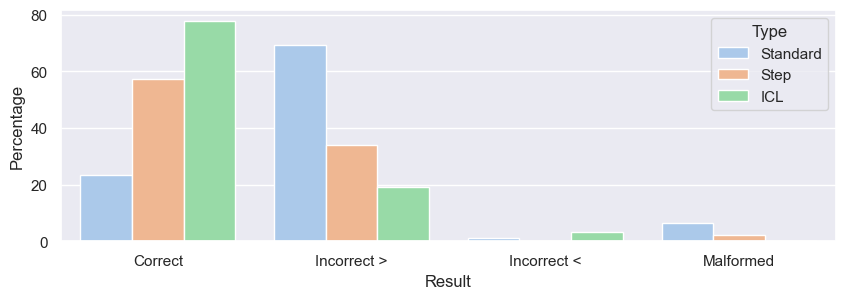

In [25]:
sns.set(rc={'figure.figsize':(10,3)})

sns.barplot(x="index", y='Count', data=to_plot, hue='Type', palette="pastel")

# Set the labels for the x and y axes
plt.ylabel('Percentage')
plt.xlabel("Result")

# Show the plot
plt.show()

## Non-0 queries

In [26]:
for query, gt in cross_queries_gt.items():
    if gt == 0:
        continue

    print("Query: {}".format(query))
    print("GT: {}".format(gt))
    print("Standard: {}".format(cross_std_tuples.get(query, "malformed")))
    print("Step: {}".format(cross_step_integer.get(query, "malformed")))
    print("ICL: {}".format(cross_icl_integer.get(query, "malformed")))
    print()

Query: grafo997.11_2_3.txt
GT: 1.0
Standard: 4
Step: 2
ICL: 1

Query: grafo541.10_3_4.txt
GT: 1.0
Standard: 1
Step: 2
ICL: 0

Query: grafo2129.11_1_2.txt
GT: 3.0
Standard: 5
Step: 15
ICL: 5

Query: grafo2964.11_2_3.txt
GT: 2.0
Standard: 3
Step: malformed
ICL: 3

Query: grafo2931.11_3_4.txt
GT: 3.0
Standard: 2
Step: 3
ICL: 2

Query: grafo2129.11_2_3.txt
GT: 1.0
Standard: 2
Step: 1
ICL: 2

Query: grafo219.11_2_3.txt
GT: 2.0
Standard: 4
Step: 3
ICL: 4

Query: grafo532.11_1_2.txt
GT: 2.0
Standard: 5
Step: 3
ICL: 3

Query: grafo1657.10_1_2.txt
GT: 7.0
Standard: 9
Step: malformed
ICL: 6

